# # FOR EVALUATION USE BY GRAB

___
# Background:
According to the World Health Organization, approximately 1.35 million people die as a result of a road traffic crash every year. Between 20 and 50 million more suffer non-fatal injuries, with many incurring a disability as a result of their injury.

Road traffic injuries cause considerable economic losses to individuals, their families, and to nations as a whole. These losses arise from the cost of treatment as well as lost productivity for those killed or disabled by their injuries, and for family members who need to take time off work or school to care for the injured. Road traffic crashes cost most countries 3% of their gross domestic product.

In my project, I will derive a classification model primarily through feature engineering to detect dangerous driving trips using time-series telemetry data from Grab. This model will be evaluated based on the AUC-ROC curve.

##### Dataset Obtained from (https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/safety.zip)

_______
# Dataset characteristics:

Dataset is a time-series of the following features for every "bookingID"

|Datapoint:     | Description:                                               | 
| ------------- |:-------------:                                             |
|bookingID      |trip id                                                     |
|Label          |1 indicates dangerous driving & 0 indicates safe driving    |

|Features (time-series):     | Description:                          |
| -------------              |:-------------:                        |
|Accuracy                    |accuracy inferred by GPS in meters     | 
|Bearing                     |GPS bearing in degree                  |
|acceleration_x              |accelerometer reading at x axis (m/s2) |
|acceleration_y              |accelerometer reading at y axis (m/s2) |
|acceleration_z              |accelerometer reading at z axis (m/s2) |
|gyro_x                      |gyroscope reading in x axis (rad/s)    |
|gyro_y                      |gyroscope reading in y axis (rad/s)    |
|gyro_z                      |gyroscope reading in z axis (rad/s)    |
|second                      |time of the record by number of seconds|
|Speed                       |speed measured by GPS in m/s           |

____
# Engineered Features:
Features are decided upon primarily through domain knowledge and analysis of correlation with label using a pairplot.

|Engineered Features (Datapoint):|Description: |
| -------------                  |---|
|Accuracy                        |Median Accuracy value with respect to range of timeseries data. If Median Accuracy is not available, Min Accuracy value is used instead 
|Bearing_delta                   |Standard Deviation of the difference between each timeseries datapoint
|acceleration_x                  |Number of threshold crossovers with threshold set at 0
|acceleration_y                  |Number of threshold crossovers with threshold set at Mean of acceleration_y
|acceleration_z                  |Number of threshold crossovers with threshold set at Mean of acceleration_z
|gyro_x                          |Max gyro_x value - Min gyro_z value
|gyro_y                          |Max gyro_y value - Min gyro_z value
|gyro_z                          |Max gyro_z value - Min gyro_z value
|Speed                           |Mean of Speed in timeseries data
|missing_rng                     |Number of missing values in the range of timeseries data

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.pyplot as plt
from pprint import pprint
sns.set()
from pathlib import Path

In [2]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from keras.models import load_model

Using TensorFlow backend.


In [3]:
# Read features .csv file to ipynb
df_features = pd.read_csv('safety/data_cleaned_features.csv')
# Read labels .csv file to ipynb
df_labels = pd.read_csv('safety/data_cleaned_labels.csv')

In [ ]:
# If available, Read combined .csv file to ipynb
df_combined = pd.read_csv('safety/data_cleaned_combined.csv')

# Else run the following


In [4]:
# sns.pairplot(df_engineered_features, hue='label')
df_engineered_features_combined = df_engineered_features.set_index('ID').join(df_labels.set_index('bookingID'))
df_engineered_features_combined.head(10)

,Accuracy,Bearing_delta,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,Speed,missing_rng,label
ID,,,,,,,,,,,
0,4.000,24.884408,840.0,881.0,762.0,0.830909,1.079655,1.104699,9.004787,588.0,0
1,3.474,9.901822,739.0,105.0,537.0,0.251903,1.149020,0.356396,8.019369,198.0,1
2,3.000,40.149162,58.0,9.0,69.0,0.437379,0.893696,0.381791,3.157213,632.0,1
4,10.000,18.359159,921.0,957.0,908.0,0.859239,1.159158,0.853409,6.150996,2.0,1
6,4.050,18.636297,210.0,181.0,306.0,0.615752,1.153924,0.712880,4.628921,1.0,0
7,3.000,18.295717,73.0,250.0,419.0,1.339190,0.950630,1.385622,12.176386,12.0,0
8,5.059,27.750184,370.0,55.0,70.0,0.564484,0.747498,0.158203,5.384260,79.0,0
10,4.996,26.617731,54.0,102.0,298.0,0.537964,0.929550,0.394135,8.702027,1.0,0
11,3.000,24.222294,59.0,27.0,68.0,1.158811,1.010982,0.532674,6.659024,76.0,0


# Pairplot of Engineered Features

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


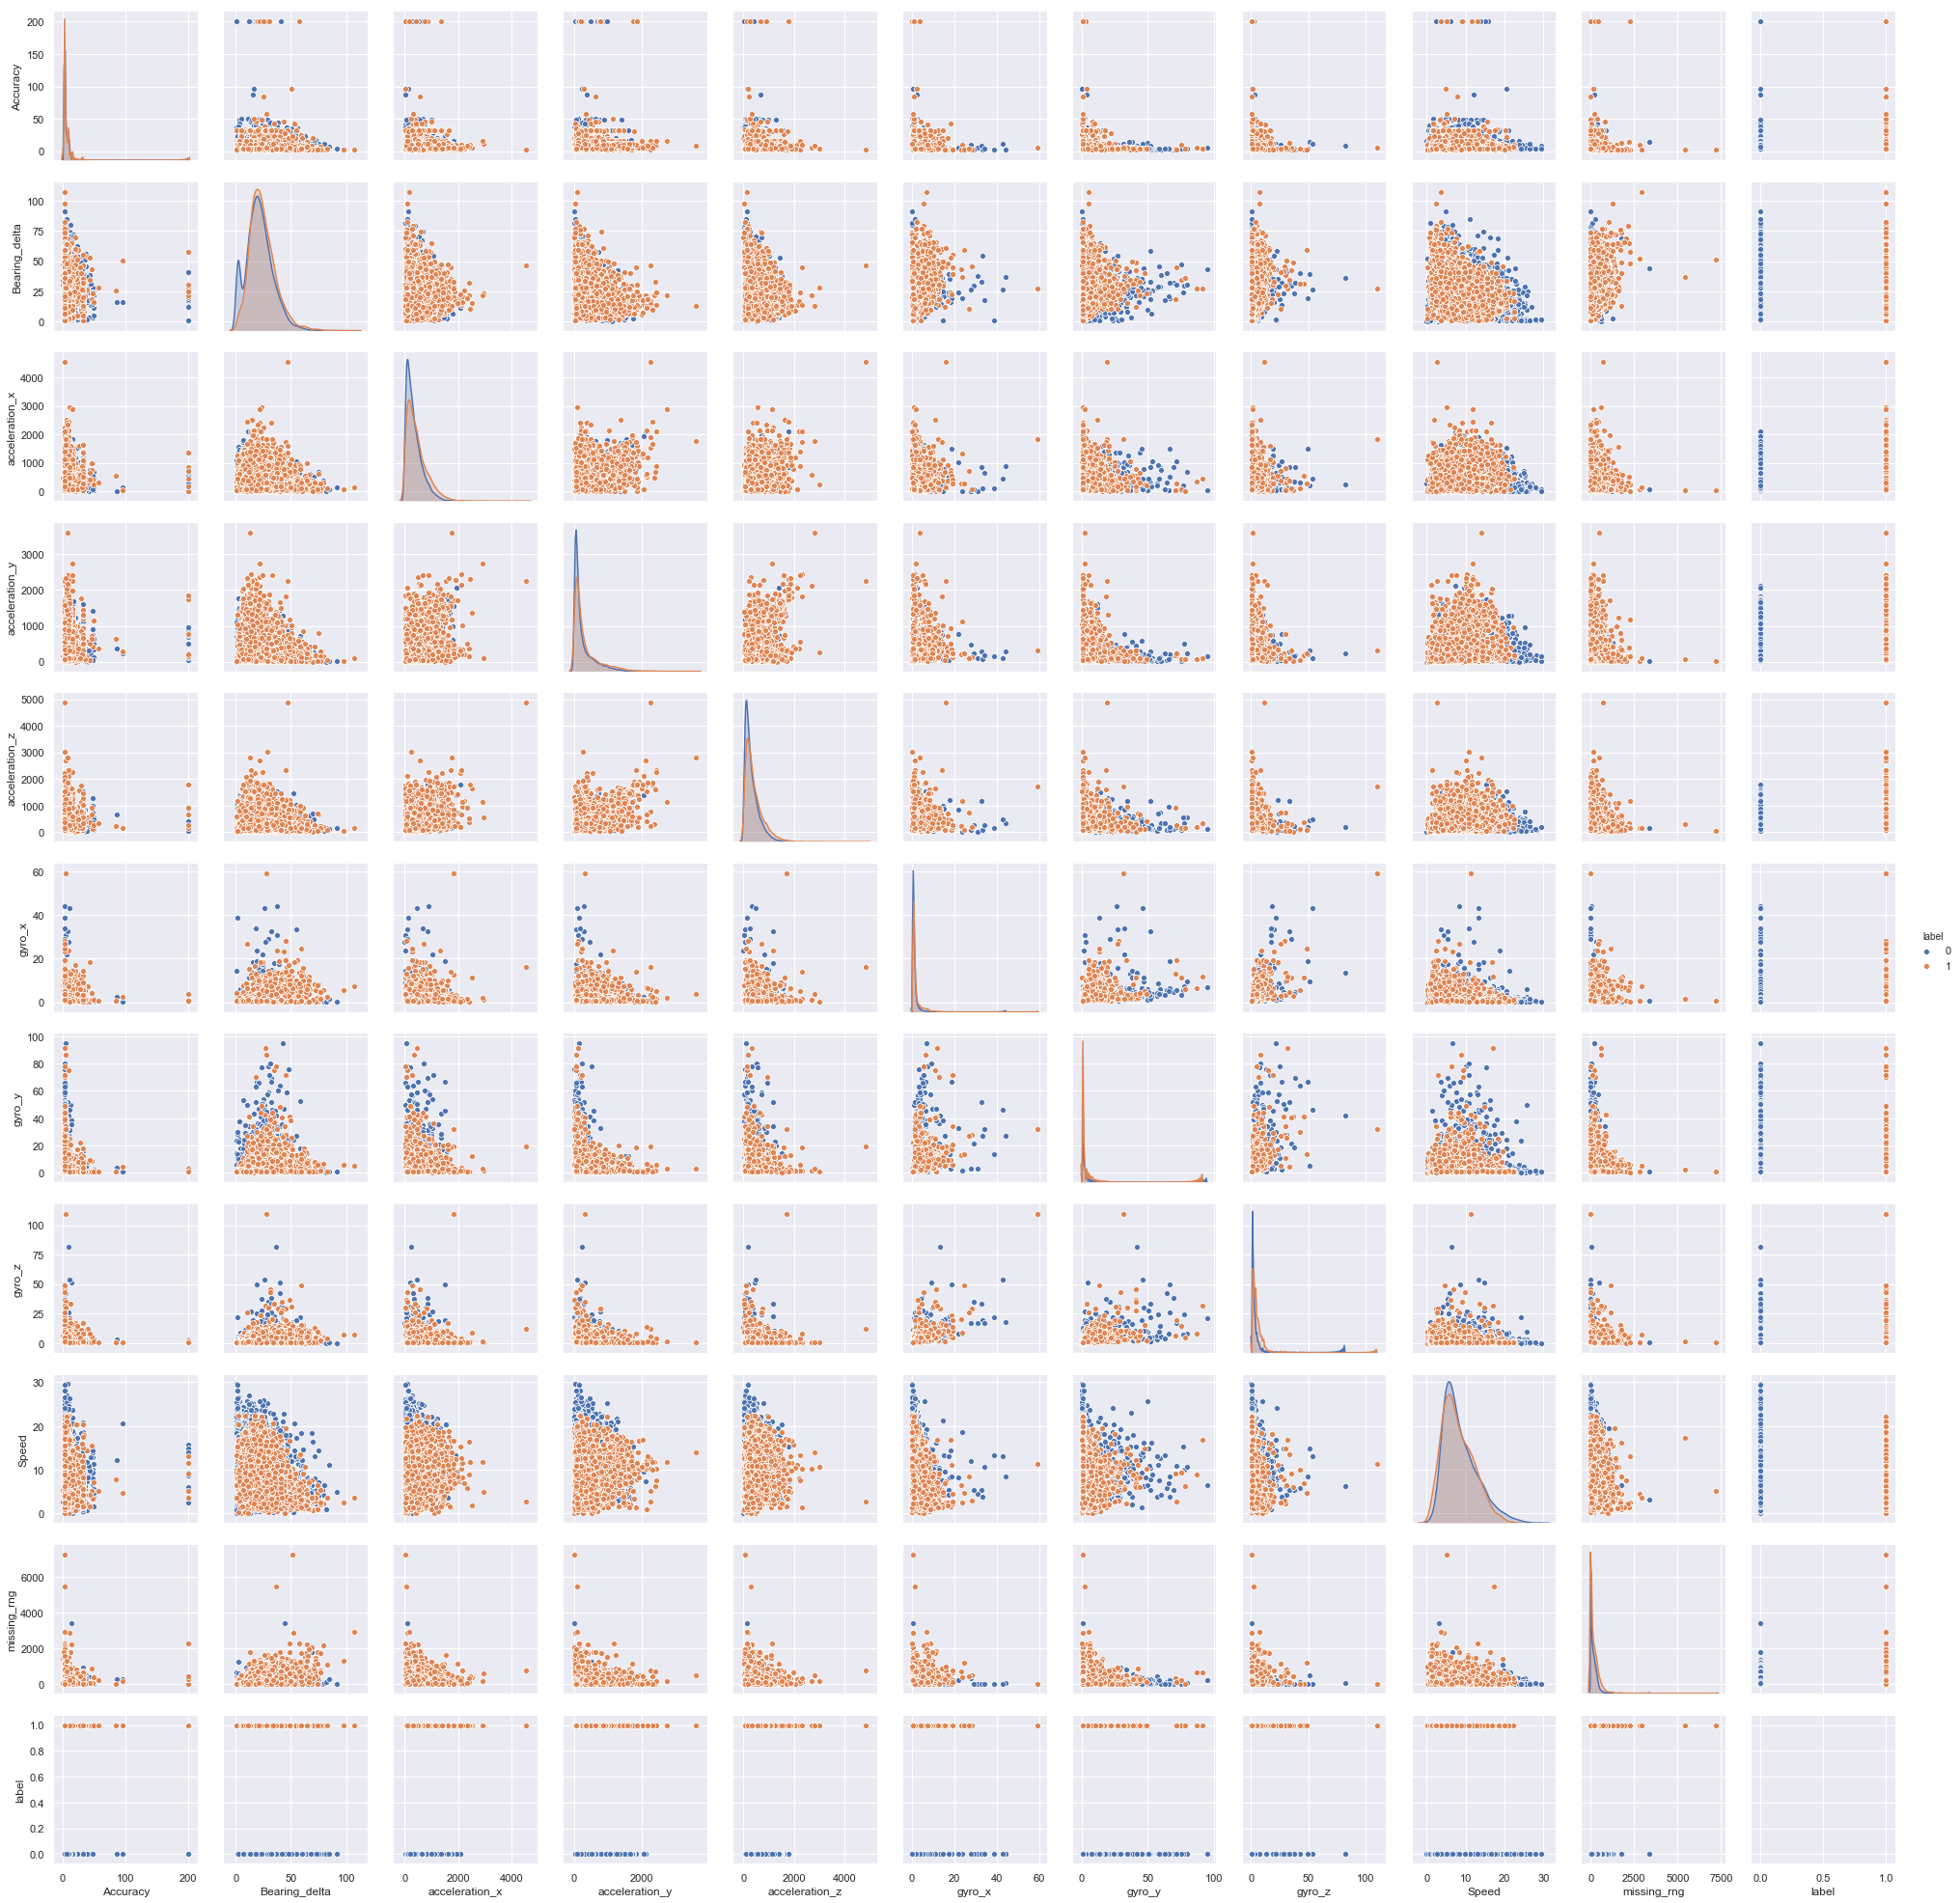

In [5]:
sns.pairplot(df_engineered_features_combined, hue='label')

In [6]:
features_col=['Accuracy', 'Bearing_delta', 
              'acceleration_x', 'acceleration_y', 'acceleration_z', 
              'gyro_x', 'gyro_y', 'gyro_z', 
              'Speed', 'missing_rng']

In [7]:
# Percentage of safe driving labels
100 - len(df_labels[df_labels['label']==1])/len(df_labels) *100

75.10273629347499

In [8]:
df_combined.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0


In [9]:
# Convert bookingIDs to dataframe
def convert_to_df(ids, dataset):
    return dataset.loc[dataset['bookingID']==ids].reset_index(drop=True)

def graph_bookingID(ID):
    bookingid = df_combined.loc[df_combined['bookingID']==ID]
    label = 'BookingID ' + str(ID) + ' (Label ' + str(bookingid['label'].iloc[0]) + ')'
    bookingid = bookingid.drop(['bookingID'],axis=1)
    print(bookingid.describe())


    accuracy = bookingid.loc[:, ['Accuracy', 'second']]
    acceleration_all = bookingid.loc[:, ['acceleration_x', 'acceleration_y', 'acceleration_z', 'second']]
    gyro_all = bookingid.loc[:, ['gyro_x', 'gyro_y', 'gyro_z', 'second']]
    speed = bookingid.loc[:, ['Speed', 'second']]
    
    f, axes = plt.subplots(4, 1, figsize=(20,20))
    graphs = [accuracy, acceleration_all, gyro_all, speed]

    count=0
    for g in graphs:
        g.plot(x='second', ax=axes[count])
        count +=1
    axes[0].set_title(label, fontsize=16)

In [10]:
print(df_combined.shape)
print(df_combined.dtypes)

(15876649, 12)
bookingID           int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
label               int64
dtype: object


In [11]:
convert_to_df(0, df_combined).describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1003.0,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.0
mean,0.0,10.127617,176.419864,-0.708812,-9.613829,-1.622308,0.003403,-0.006175,-0.004107,903.231306,9.004787,0.0
std,0.0,3.667800,129.251952,0.925227,0.640254,1.138741,0.065944,0.100259,0.063666,533.929149,7.196581,0.0
min,0.0,4.000000,0.037464,-4.692294,-12.764703,-6.251807,-0.392537,-0.609930,-0.731892,0.000000,0.064309,0.0
25%,0.0,8.000000,38.211140,-1.184251,-9.904376,-2.250594,-0.027035,-0.046184,-0.029853,250.500000,1.601906,0.0
50%,0.0,8.000000,144.299423,-0.724802,-9.623547,-1.608112,0.002603,-0.002345,-0.003478,1087.000000,8.522352,0.0
75%,0.0,12.000000,312.108078,-0.297726,-9.342868,-1.035463,0.033266,0.032592,0.020898,1338.500000,15.647217,0.0
max,0.0,32.000000,359.979767,4.782614,-6.119916,2.318857,0.438371,0.469724,0.372807,1589.000000,22.946083,0.0


In [12]:
print(len(df_combined['bookingID'].unique().tolist()))
df1 = df_combined.dropna()
print(len(df1['bookingID'].unique().tolist()))

19954
19954


In [13]:
print(len(df_labels['bookingID'].unique().tolist()))
df1_labels = df_labels.dropna()
print(len(df1_labels['bookingID'].unique().tolist()))

19954
19954


# Getting X data

In [217]:
from sklearn import preprocessing
print(df_engineered_features.shape)
X = df_engineered_features[features_col].values
# X = preprocessing.normalize(X)
X

(19954, 11)


array([[4.00000000e+00, 2.48844083e+01, 8.40000000e+02, ...,
        1.10469893e+00, 9.00478686e+00, 5.88000000e+02],
       [3.47400000e+00, 9.90182162e+00, 7.39000000e+02, ...,
        3.56396240e-01, 8.01936901e+00, 1.98000000e+02],
       [3.00000000e+00, 4.01491622e+01, 5.80000000e+01, ...,
        3.81790760e-01, 3.15721296e+00, 6.32000000e+02],
       ...,
       [1.07200000e+01, 3.36120291e+01, 4.94000000e+02, ...,
        5.37963860e-01, 1.27187051e+01, 2.11000000e+02],
       [3.90000000e+00, 1.13974256e+01, 3.69000000e+02, ...,
        1.45080490e+00, 6.25246678e+00, 5.00000000e+00],
       [5.70000000e+01, 2.80265299e+01, 3.12000000e+02, ...,
        4.67942437e-01, 5.20050627e+00, 1.87000000e+02]])

In [218]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-3.33975023e-01,  2.20518381e-01,  1.47244252e+00, ...,
         6.56919586e-03,  1.02718073e-01,  2.33931983e+00],
       [-4.07783003e-01, -1.03776183e+00,  1.15340008e+00, ...,
        -3.04756122e-01, -1.25337566e-01,  3.86373688e-01],
       [-4.74294375e-01,  1.50249579e+00, -9.97767320e-01, ...,
        -2.94190936e-01, -1.25058825e+00,  2.55965222e+00],
       ...,
       [ 6.08971022e-01,  9.53488775e-01,  3.79485227e-01, ...,
        -2.29216373e-01,  9.62231633e-01,  4.51471893e-01],
       [-3.48006959e-01, -9.12156759e-01, -1.53692875e-02, ...,
         1.50563803e-01, -5.34252443e-01, -5.80084275e-01],
       [ 7.10295063e+00,  4.84402681e-01, -1.95422946e-01, ...,
        -2.58348223e-01, -7.77708076e-01,  3.31290592e-01]])

# Getting y data

In [219]:
print(df_labels.shape)
y = list(df_labels['label'])
y = np.array(y)
print(y)

(19954, 2)
[0 1 1 ... 1 1 1]


In [220]:
n_classes = 2
n_samples=len(df_combined['bookingID'].unique().tolist())

# X, y = make_classification(n_samples=n_samples, n_features=9, n_informative=3, n_redundant=2, n_classes=n_classes,
#     n_clusters_per_class=2)
# Binarize the output
# y = label_binarize(y, classes=[0, 1])

n_classes = len(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(y_train))
np.bincount(y_train)
# print(list(y_train))

15963


array([12002,  3961], dtype=int64)

### Implementing Cyclic Learning Rate:
(Credits: https://github.com/bckenstler/CLR)

In [221]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [222]:
from keras import backend as K  

# Metric Functions
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Model Architecture

In [223]:
from keras.optimizers import Adam, SGD, RMSprop

# Using triangular learning rate policy
# base_lr (which is the lower boundary in the cycle) is 00009
clr_triangular = CyclicLR(mode='triangular')

adam = Adam(lr=0.00009, decay=0.0008)
# adam = SGD(lr=0.0001, decay=0.0008, momentum=0.9)

In [224]:
# from sklearn.linear_model import LogisticRegression
from keras.layers import Input, Conv1D, Dense, MaxPool1D, Activation, Dropout
from keras.models import Model, Sequential
classifier = Sequential()
#Input Layer
classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal', input_dim=len(features_col)))
classifier.add(Dropout(0.15))
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compile Model
classifier.compile(optimizer=adam, loss='binary_crossentropy', metrics =['accuracy', precision, recall, auroc])

In [225]:
from keras.callbacks import ModelCheckpoint

bestValidationCheckpointer = ModelCheckpoint('train_model.h5', monitor='val_auroc', save_best_only=True, verbose=0)

# Stratefied K-Fold Cross Validation
 
Methodology (For each Fold):
1. Upsample Label 1 of X_train/y_train to ratio of 0.7 of Label 0
2. Downsample Label 0 of X_train/y_train to get balanced labels for train data 
3. Fit Classfier using new Train Data (Triangular Learning Rate)
4. Append hist to history for tracking

In [226]:
# Import Dependencies
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE 
import random
import timeit

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [227]:
# Initialise Model Parameters
epochs = 75
bs = 32 
validation_data=(X_test, y_test)

# Keep track of model history
history = []
auc_score = []
TrainSet_ConfusionMatrix = []
TestSet_ConfusionMatrix = []
fpr_and_tpr = []

# Stratified K-Fold Cross Validation 
skf = StratifiedKFold(n_splits=5, random_state=None)
foldcount=0
for train_index, test_index in skf.split(X,y):
    print("K-Fold ", str(foldcount), ":")
    print("Train:", train_index, "Validation:", test_index) 
    
    # Initial Train & Test set for current fold 
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    # Upsampling using SMOTE
    sm = SMOTE(random_state=12, ratio=0.7)
    x_res, y_res = sm.fit_sample(X_train, y_train)

    # Downsampling
    # Indicies of each class' observations
    i_class0 = np.where(y_res == 0)[0]
    i_class1 = np.where(y_res == 1)[0]
    # Number of observations in each class
    n_class0 = len(i_class0)
    n_class1 = len(i_class1)
    # For every observation of class 0, randomly sample from class 1 without replacement
    i_class1_downsampled = np.random.choice(i_class0, size=n_class1, replace=False)
    new_y_res_idx = list(i_class1_downsampled) + list(i_class1)
    for i in range(3):
        random.shuffle(new_y_res_idx)
        
    # New train data after upsampling of label 1 class & downsampling of label 0 class
    X_train = x_res[new_y_res_idx]
    y_train = y_res[new_y_res_idx]
    print(len(X_train))
    print(len(y_train))
    print(np.bincount(y_train), '\n') # balanced dataset
    
    # Start Time
    startTime = timeit.default_timer()

    # Fit Model
    hist = classifier.fit(X_train, y_train,
                             epochs=epochs, batch_size=bs, verbose=1, 
                             validation_data=validation_data,
                             callbacks=[clr_triangular])
    
    # End Time 
    elapsedTime = timeit.default_timer() - startTime
    print("Time taken for the Network to train : ", elapsedTime)
    
    # Append results
    y_train_pred = classifier.predict(X_train)>0.5
    y_pred_model = classifier.predict(X_test)
    y_test_pred = (y_pred_model>0.5)

    fpr_model, tpr_model, thresholds_model = roc_curve(y_test, y_pred_model.ravel())
    auc_model = auc(fpr_model, tpr_model)
    print(auc_model, '\n\n')
    
    history.append(hist)
    auc_score.append(auc_model)
    TrainSet_ConfusionMatrix.append(confusion_matrix(y_train, y_train_pred))
    TestSet_ConfusionMatrix.append(confusion_matrix(y_test, y_test_pred))
    fpr_and_tpr.append((fpr_model, tpr_model))
    
print("Done!")

K-Fold  0 :
Train: [ 3966  3967  3968 ... 19951 19952 19953] Validation: [   0    1    2 ... 4168 4172 4173]
16782
16782
[8391 8391]
Train on 16782 samples, validate on 3991 samples
Epoch 1/75
16782/16782 [==============================] - 2s 105us/step - loss: 0.6932 - acc: 0.5012 - precision: 0.2304 - recall: 0.4591 - auroc: 0.4997 - val_loss: 0.6923 - val_acc: 0.7477 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auroc: 0.5000
Epoch 2/75
16782/16782 [==============================] - 2s 90us/step - loss: 0.6453 - acc: 0.6030 - precision: 0.5200 - recall: 0.4862 - auroc: 0.6573 - val_loss: 0.6808 - val_acc: 0.5678 - val_precision: 0.3348 - val_recall: 0.7171 - val_auroc: 0.6828
Epoch 3/75
16782/16782 [==============================] - 1s 86us/step - loss: 0.6246 - acc: 0.6329 - precision: 0.6233 - recall: 0.6728 - auroc: 0.6941 - val_loss: 0.6313 - val_acc: 0.6166 - val_precision: 0.3571 - val_recall: 0.6520 - val_auroc: 0.6857
Epoch 4/75
16782/16782 [====================

16782/16782 [==============================] - 2s 90us/step - loss: 0.5995 - acc: 0.6475 - precision: 0.6307 - recall: 0.7125 - auroc: 0.7211 - val_loss: 0.6095 - val_acc: 0.6174 - val_precision: 0.3606 - val_recall: 0.6687 - val_auroc: 0.6974
Epoch 65/75
16782/16782 [==============================] - 2s 90us/step - loss: 0.5991 - acc: 0.6500 - precision: 0.6342 - recall: 0.7132 - auroc: 0.7213 - val_loss: 0.6238 - val_acc: 0.6011 - val_precision: 0.3533 - val_recall: 0.7005 - val_auroc: 0.6971
Epoch 66/75
16782/16782 [==============================] - 2s 90us/step - loss: 0.6000 - acc: 0.6504 - precision: 0.6337 - recall: 0.7181 - auroc: 0.7222 - val_loss: 0.6168 - val_acc: 0.6096 - val_precision: 0.3575 - val_recall: 0.6875 - val_auroc: 0.6966
Epoch 67/75
16782/16782 [==============================] - 2s 90us/step - loss: 0.5985 - acc: 0.6491 - precision: 0.6304 - recall: 0.7164 - auroc: 0.7210 - val_loss: 0.6132 - val_acc: 0.6144 - val_precision: 0.3589 - val_recall: 0.6738 - val_au

16784/16784 [==============================] - 2s 92us/step - loss: 0.6016 - acc: 0.6477 - precision: 0.6321 - recall: 0.7119 - auroc: 0.7194 - val_loss: 0.6199 - val_acc: 0.6016 - val_precision: 0.3554 - val_recall: 0.7096 - val_auroc: 0.6950
Epoch 21/75
16784/16784 [==============================] - 2s 96us/step - loss: 0.6026 - acc: 0.6499 - precision: 0.6326 - recall: 0.7138 - auroc: 0.7181 - val_loss: 0.6213 - val_acc: 0.5998 - val_precision: 0.3540 - val_recall: 0.7134 - val_auroc: 0.6945
Epoch 22/75
16784/16784 [==============================] - 2s 101us/step - loss: 0.6021 - acc: 0.6491 - precision: 0.6291 - recall: 0.7225 - auroc: 0.7164 - val_loss: 0.6180 - val_acc: 0.6036 - val_precision: 0.3561 - val_recall: 0.7064 - val_auroc: 0.6952
Epoch 23/75
16784/16784 [==============================] - 2s 94us/step - loss: 0.6015 - acc: 0.6508 - precision: 0.6324 - recall: 0.7208 - auroc: 0.7202 - val_loss: 0.6193 - val_acc: 0.6016 - val_precision: 0.3544 - val_recall: 0.7056 - val_a

Epoch 52/75
16784/16784 [==============================] - 1s 87us/step - loss: 0.5982 - acc: 0.6516 - precision: 0.6336 - recall: 0.7153 - auroc: 0.7235 - val_loss: 0.6207 - val_acc: 0.6031 - val_precision: 0.3543 - val_recall: 0.7004 - val_auroc: 0.6968
Epoch 53/75
16784/16784 [==============================] - 2s 95us/step - loss: 0.5988 - acc: 0.6532 - precision: 0.6347 - recall: 0.7189 - auroc: 0.7231 - val_loss: 0.6169 - val_acc: 0.6044 - val_precision: 0.3538 - val_recall: 0.6915 - val_auroc: 0.6965
Epoch 54/75
16784/16784 [==============================] - 1s 89us/step - loss: 0.5991 - acc: 0.6519 - precision: 0.6353 - recall: 0.7174 - auroc: 0.7223 - val_loss: 0.6185 - val_acc: 0.6031 - val_precision: 0.3536 - val_recall: 0.6947 - val_auroc: 0.6963
Epoch 55/75
16784/16784 [==============================] - 1s 88us/step - loss: 0.5968 - acc: 0.6511 - precision: 0.6325 - recall: 0.7170 - auroc: 0.7234 - val_loss: 0.6177 - val_acc: 0.6034 - val_precision: 0.3538 - val_recall: 0.6

16784/16784 [==============================] - 3s 150us/step - loss: 0.5950 - acc: 0.6512 - precision: 0.6360 - recall: 0.7083 - auroc: 0.7263 - val_loss: 0.6191 - val_acc: 0.6089 - val_precision: 0.3584 - val_recall: 0.6923 - val_auroc: 0.6993
Epoch 40/75
16784/16784 [==============================] - 2s 104us/step - loss: 0.5939 - acc: 0.6540 - precision: 0.6388 - recall: 0.7143 - auroc: 0.7277 - val_loss: 0.6171 - val_acc: 0.6106 - val_precision: 0.3589 - val_recall: 0.6874 - val_auroc: 0.6984
Epoch 41/75
16784/16784 [==============================] - 2s 105us/step - loss: 0.5941 - acc: 0.6529 - precision: 0.6351 - recall: 0.7167 - auroc: 0.7270 - val_loss: 0.6159 - val_acc: 0.6116 - val_precision: 0.3593 - val_recall: 0.6852 - val_auroc: 0.6988
Epoch 42/75
16784/16784 [==============================] - 2s 109us/step - loss: 0.5945 - acc: 0.6546 - precision: 0.6381 - recall: 0.7131 - auroc: 0.7288 - val_loss: 0.6148 - val_acc: 0.6131 - val_precision: 0.3601 - val_recall: 0.6836 - va

Epoch 71/75
16784/16784 [==============================] - 2s 104us/step - loss: 0.5937 - acc: 0.6525 - precision: 0.6359 - recall: 0.7115 - auroc: 0.7289 - val_loss: 0.6159 - val_acc: 0.6119 - val_precision: 0.3584 - val_recall: 0.6826 - val_auroc: 0.6982
Epoch 72/75
16784/16784 [==============================] - 2s 103us/step - loss: 0.5940 - acc: 0.6528 - precision: 0.6370 - recall: 0.7129 - auroc: 0.7306 - val_loss: 0.6165 - val_acc: 0.6109 - val_precision: 0.3581 - val_recall: 0.6835 - val_auroc: 0.6985
Epoch 73/75
16784/16784 [==============================] - 2s 126us/step - loss: 0.5927 - acc: 0.6542 - precision: 0.6386 - recall: 0.7132 - auroc: 0.7288 - val_loss: 0.6167 - val_acc: 0.6119 - val_precision: 0.3592 - val_recall: 0.6859 - val_auroc: 0.6988
Epoch 74/75
16784/16784 [==============================] - 2s 95us/step - loss: 0.5928 - acc: 0.6544 - precision: 0.6380 - recall: 0.7159 - auroc: 0.7295 - val_loss: 0.6158 - val_acc: 0.6114 - val_precision: 0.3574 - val_recall: 

Epoch 27/75
16784/16784 [==============================] - 2s 123us/step - loss: 0.5967 - acc: 0.6534 - precision: 0.6359 - recall: 0.7160 - auroc: 0.7244 - val_loss: 0.6138 - val_acc: 0.6176 - val_precision: 0.3636 - val_recall: 0.6866 - val_auroc: 0.7026
Epoch 28/75
16784/16784 [==============================] - 2s 144us/step - loss: 0.5981 - acc: 0.6528 - precision: 0.6361 - recall: 0.7130 - auroc: 0.7228 - val_loss: 0.6141 - val_acc: 0.6171 - val_precision: 0.3638 - val_recall: 0.6893 - val_auroc: 0.7024
Epoch 29/75
16784/16784 [==============================] - 2s 95us/step - loss: 0.5985 - acc: 0.6509 - precision: 0.6340 - recall: 0.7136 - auroc: 0.7221 - val_loss: 0.6147 - val_acc: 0.6166 - val_precision: 0.3632 - val_recall: 0.6899 - val_auroc: 0.7027
Epoch 30/75
16784/16784 [==============================] - 1s 89us/step - loss: 0.5978 - acc: 0.6559 - precision: 0.6396 - recall: 0.7134 - auroc: 0.7237 - val_loss: 0.6161 - val_acc: 0.6159 - val_precision: 0.3634 - val_recall: 0

Epoch 59/75
16784/16784 [==============================] - 2s 99us/step - loss: 0.5963 - acc: 0.6565 - precision: 0.6385 - recall: 0.7207 - auroc: 0.7254 - val_loss: 0.6132 - val_acc: 0.6209 - val_precision: 0.3663 - val_recall: 0.6877 - val_auroc: 0.7049
Epoch 60/75
16784/16784 [==============================] - 2s 96us/step - loss: 0.5956 - acc: 0.6557 - precision: 0.6389 - recall: 0.7138 - auroc: 0.7261 - val_loss: 0.6125 - val_acc: 0.6196 - val_precision: 0.3649 - val_recall: 0.6826 - val_auroc: 0.7047
Epoch 61/75
16784/16784 [==============================] - 2s 92us/step - loss: 0.5964 - acc: 0.6556 - precision: 0.6398 - recall: 0.7147 - auroc: 0.7250 - val_loss: 0.6137 - val_acc: 0.6204 - val_precision: 0.3660 - val_recall: 0.6888 - val_auroc: 0.7047
Epoch 62/75
16784/16784 [==============================] - 2s 90us/step - loss: 0.5959 - acc: 0.6565 - precision: 0.6392 - recall: 0.7215 - auroc: 0.7253 - val_loss: 0.6114 - val_acc: 0.6211 - val_precision: 0.3659 - val_recall: 0.6

Epoch 15/75
16784/16784 [==============================] - 2s 113us/step - loss: 0.5969 - acc: 0.6551 - precision: 0.6400 - recall: 0.7106 - auroc: 0.7287 - val_loss: 0.6154 - val_acc: 0.6181 - val_precision: 0.3635 - val_recall: 0.6814 - val_auroc: 0.7022
Epoch 16/75
16784/16784 [==============================] - 2s 111us/step - loss: 0.5957 - acc: 0.6542 - precision: 0.6389 - recall: 0.7088 - auroc: 0.7260 - val_loss: 0.6169 - val_acc: 0.6179 - val_precision: 0.3640 - val_recall: 0.6849 - val_auroc: 0.7025
Epoch 17/75
16784/16784 [==============================] - 2s 115us/step - loss: 0.5975 - acc: 0.6556 - precision: 0.6397 - recall: 0.7131 - auroc: 0.7268 - val_loss: 0.6160 - val_acc: 0.6184 - val_precision: 0.3640 - val_recall: 0.6840 - val_auroc: 0.7020
Epoch 18/75
16784/16784 [==============================] - 2s 113us/step - loss: 0.5956 - acc: 0.6549 - precision: 0.6390 - recall: 0.7055 - auroc: 0.7268 - val_loss: 0.6158 - val_acc: 0.6174 - val_precision: 0.3630 - val_recall:

Epoch 47/75
16784/16784 [==============================] - 2s 91us/step - loss: 0.5950 - acc: 0.6555 - precision: 0.6408 - recall: 0.7127 - auroc: 0.7279 - val_loss: 0.6172 - val_acc: 0.6159 - val_precision: 0.3611 - val_recall: 0.6811 - val_auroc: 0.7022
Epoch 48/75
16784/16784 [==============================] - 2s 92us/step - loss: 0.5944 - acc: 0.6562 - precision: 0.6420 - recall: 0.7088 - auroc: 0.7290 - val_loss: 0.6164 - val_acc: 0.6181 - val_precision: 0.3628 - val_recall: 0.6811 - val_auroc: 0.7018
Epoch 49/75
16784/16784 [==============================] - 2s 90us/step - loss: 0.5946 - acc: 0.6581 - precision: 0.6430 - recall: 0.7109 - auroc: 0.7284 - val_loss: 0.6165 - val_acc: 0.6186 - val_precision: 0.3633 - val_recall: 0.6801 - val_auroc: 0.7017
Epoch 50/75
16784/16784 [==============================] - 1s 89us/step - loss: 0.5937 - acc: 0.6580 - precision: 0.6435 - recall: 0.7086 - auroc: 0.7302 - val_loss: 0.6157 - val_acc: 0.6186 - val_precision: 0.3631 - val_recall: 0.6

In [228]:
# Graph Metrics
graph_metrics = list(history[0].history.keys())
graph_metrics

['val_loss',
 'val_acc',
 'val_precision',
 'val_recall',
 'val_auroc',
 'loss',
 'acc',
 'precision',
 'recall',
 'auroc']

K-Fold 0
K-Fold 1
K-Fold 2
K-Fold 3
K-Fold 4


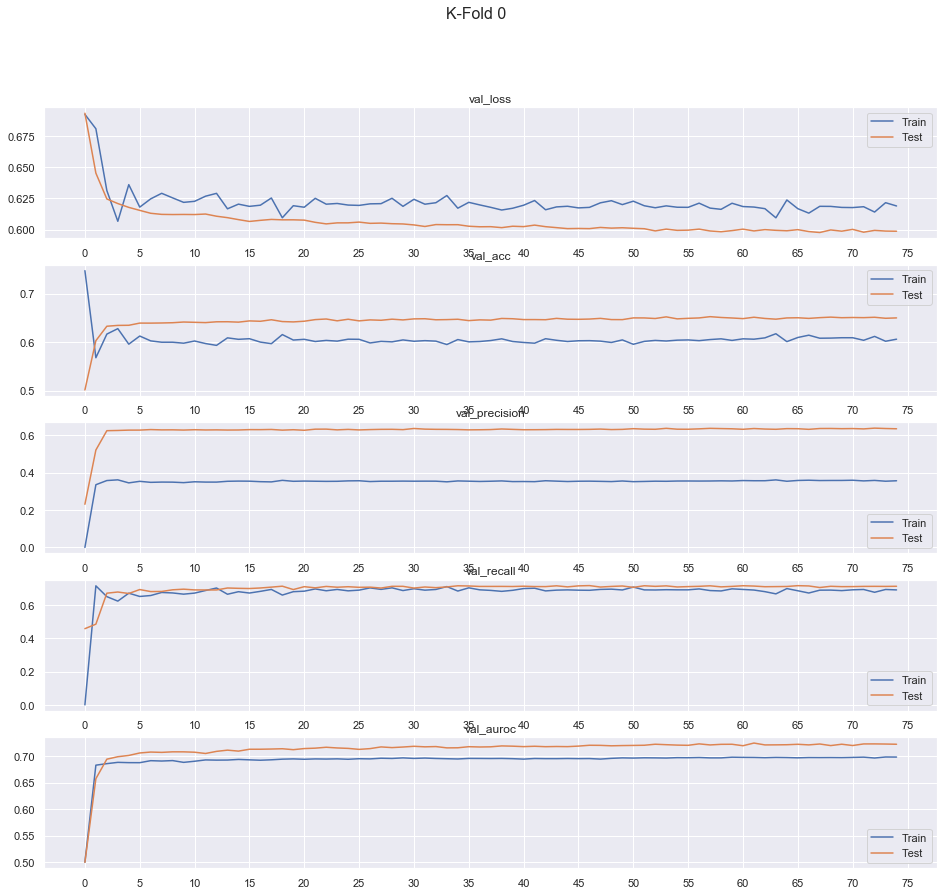

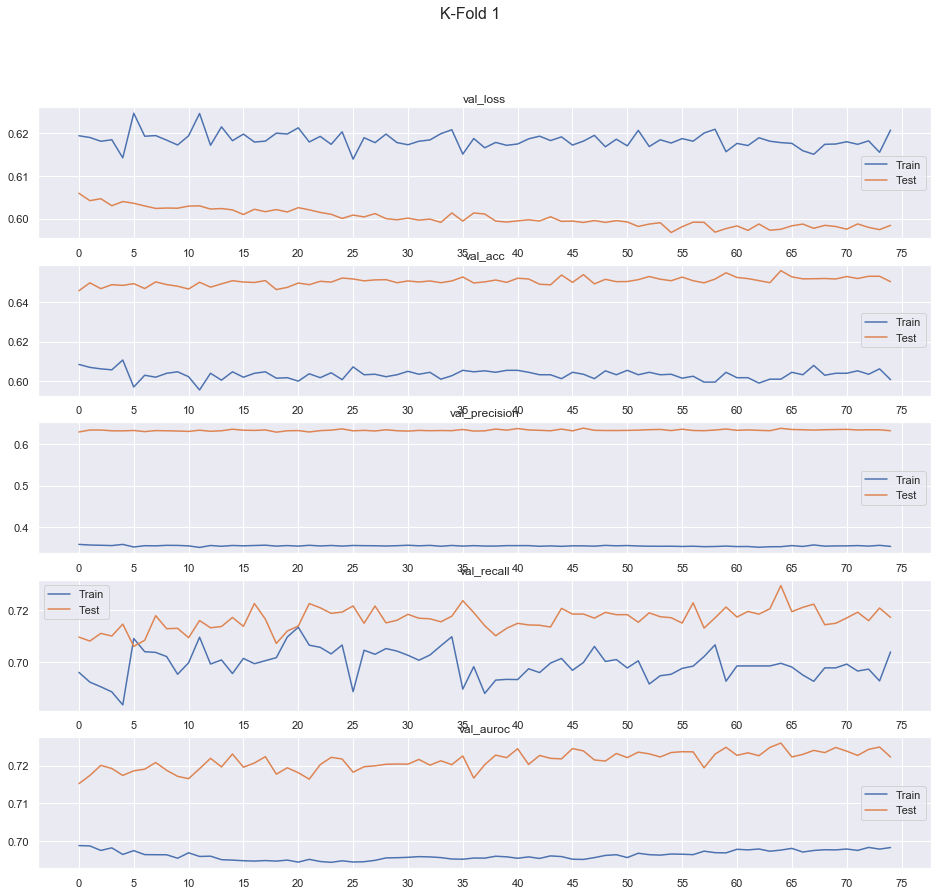

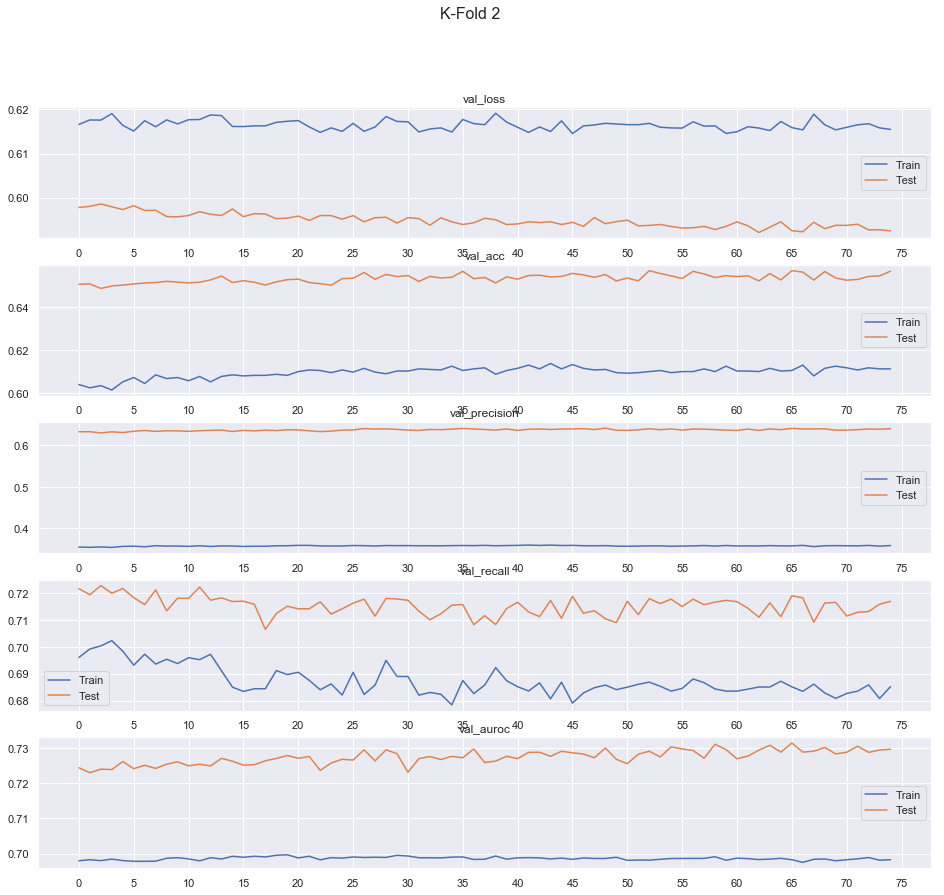

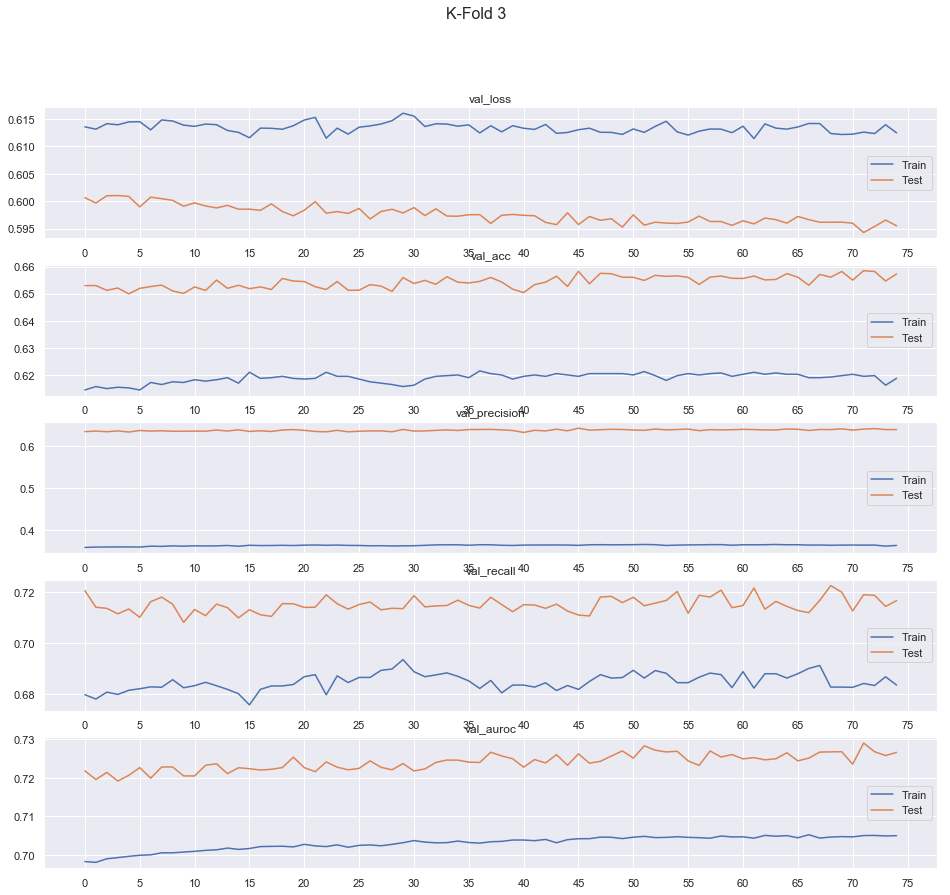

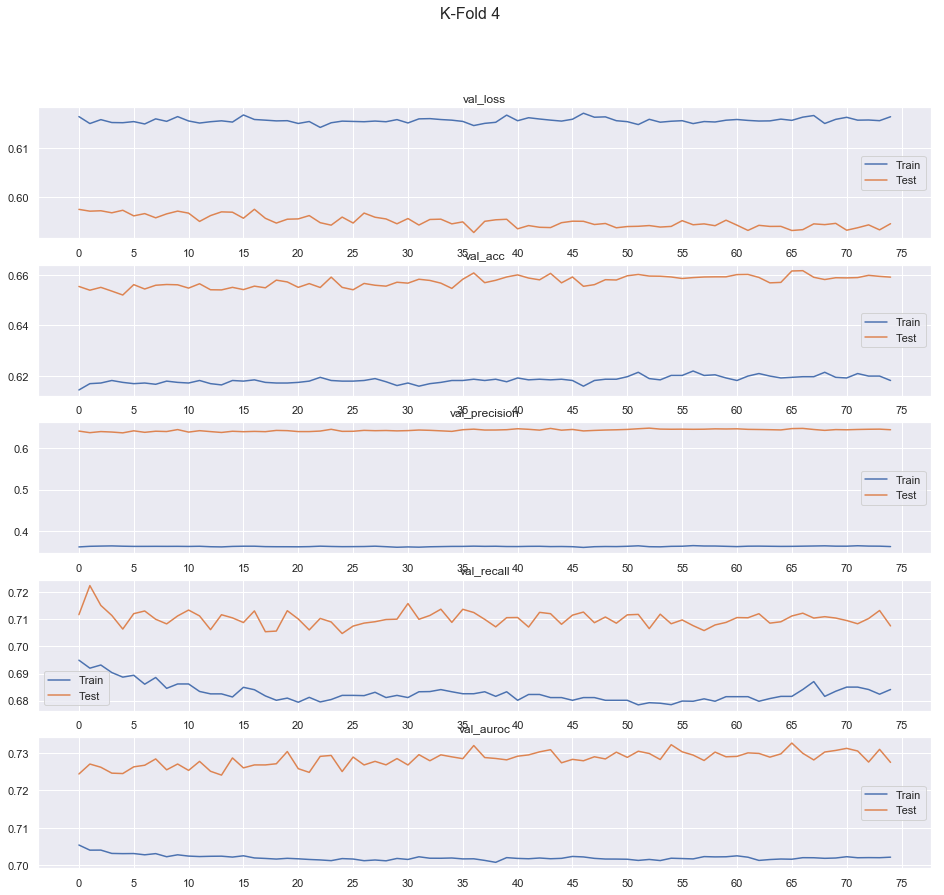

In [229]:
# Graphs
no_of_graphs = int(len(graph_metrics)/2)

count = 0
foldcount = 0
for hist in history:
    print("K-Fold " + str(foldcount))
    f, axes = plt.subplots(no_of_graphs, 1, figsize=(16, 14))
    
    for i in range(no_of_graphs):
        f.suptitle("K-Fold " + str(foldcount), fontsize=16)
        
        axes[i].set_title(graph_metrics[i])
        axes[i].plot(hist.history[graph_metrics[i]], label='Train')
        axes[i].plot(hist.history[graph_metrics[i+no_of_graphs]], label='Test')
        axes[i].legend()
        count+=1    
    for i in axes:
        i.set_xticks(range(0,epochs+1,5))
    
    count = 0
    foldcount+=1

# Confusion Matrix

In [230]:
# Function to combine array of Confusion Matrixes
def combine_CM(array_of_CM):
    combine = [tn, fp, fn, tp] = [0, 0, 0, 0]
    
    for CM in array_of_CM:
        count=0
        for value in CM.ravel():
            combine[count] += value
            count+=1

    result_array = np.array([[combine[0], combine[1]],
                             [combine[2], combine[3]]])
    return result_array

<Figure size 1800x3600 with 0 Axes>

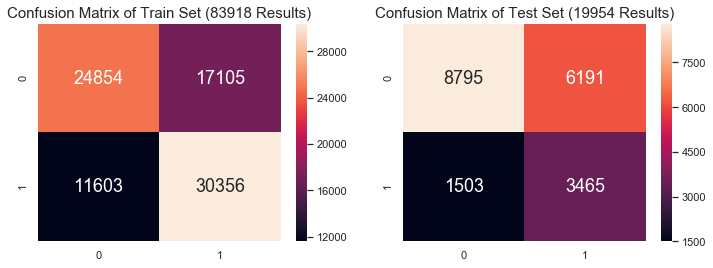

In [231]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (25,50))
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(combine_CM(TrainSet_ConfusionMatrix),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(combine_CM(TestSet_ConfusionMatrix), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[0].set_title("Confusion Matrix of Train Set (" + str(combine_CM(TrainSet_ConfusionMatrix).ravel().sum()) + " Results)",
                 fontsize=15)
axes[1].set_title("Confusion Matrix of Test Set (" + str(combine_CM(TestSet_ConfusionMatrix).ravel().sum()) + " Results)",
                 fontsize=15);

<img src="Images/ConfusionMatrix_Eg.png">

(Credits: https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

Mean AUC-ROC score is 0.7118


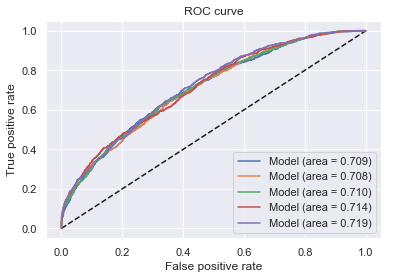

In [232]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

mean_auc_score = np.mean(auc_score)
print("Mean AUC-ROC score is %.4f" % mean_auc_score)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

count=0
for i in range(len(auc_score)):
    plt.plot(fpr_and_tpr[i][0], fpr_and_tpr[i][1], label='Model (area = {:.3f})'.format(auc_score[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate (Sensitivity/Recall)')
    plt.title('ROC curve')
    plt.legend(loc='best')
plt.show()

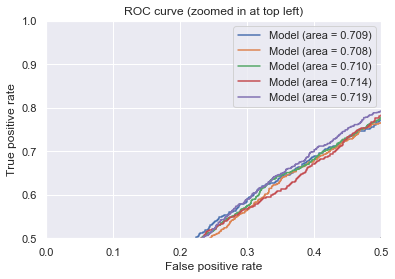

In [233]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.5, 1)
plt.plot([0, 1], [0, 1], 'k--')

for i in range(len(auc_score)):
    plt.plot(fpr_and_tpr[i][0], fpr_and_tpr[i][1], label='Model (area = {:.3f})'.format(auc_score[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate (Sensitivity/Recall)')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
plt.show()

In [234]:
classifier.save("train_model_ver1.h5")
print("Saved model to disk")

Saved model to disk


_______________________________________________________________________________________________________________________________
## Load Model, only follows result of the last fold

In [235]:
# Computed with improved Engineered Features
loaded_model = load_model("train_model_ver1.h5", custom_objects={'auroc':auroc, 'precision':precision, 'recall':recall})
print("Model loaded from disk")

Model loaded from disk


0.719180745028345 



Text(0.5, 1.0, 'Confusion Matrix of Test Set')

<Figure size 1800x3600 with 0 Axes>

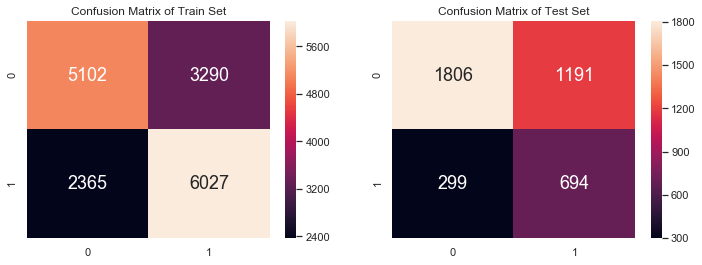

In [236]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_train_pred_raw = loaded_model.predict(X_train)
y_train_pred = y_train_pred_raw>0.5
y_test_pred_raw = loaded_model.predict(X_test)
y_test_pred = y_pred_model>0.5

fpr_model, tpr_model, thresholds_model = roc_curve(y_test, y_test_pred_raw.ravel())
auc_model = auc(fpr_model, tpr_model)

# print(y_pred_model, '\n')
# print(fpr_model)
# print(tpr_model) 
# print(thresholds_model, '\n')
print(auc_model, '\n')

from sklearn.metrics import confusion_matrix

plt.figure(figsize = (25,50))
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[0].set_title("Confusion Matrix of Train Set")
axes[1].set_title("Confusion Matrix of Test Set")

<img src="Images/ConfusionMatrix_Eg.png">

(Credits: https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

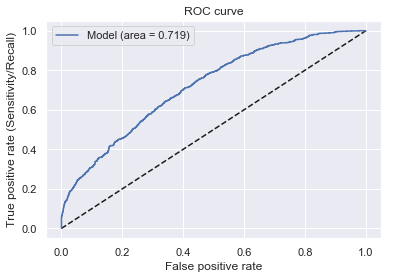

In [237]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_model, tpr_model, label='Model (area = {:.3f})'.format(auc_model))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate (Sensitivity/Recall)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

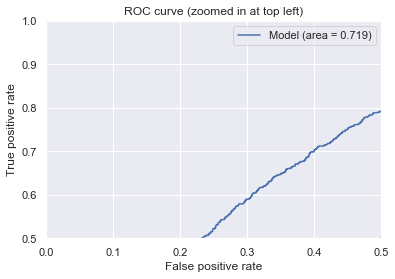

In [238]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.5, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_model, tpr_model, label='Model (area = {:.3f})'.format(auc_model))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate (Sensitivity/Recall)')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## Executive Summary:
With this model, I hope to detect dangerous driving in real-time and prevent more of such incidents. This is especially relevant with the advent of autonomous vehicles. 
For example, if an autonomous vehicle detects that the driver under substance abuse is driving dangerously, it can pull over and prevent accidents.

## Future Work:
Given the multi-faceted factors that contribute to dangerous driving, the current analysis is limited. In order to build a model that is able to detect in real-time or even before a dangerous driving incident occurs, more data and prediction methods should be explored (E.g. Using Computer Vision to analyse Traffic Data). The combination of these techniques will help yield a more accurate prediction.